# Parameters
Edge_types mapping: 10_10: 0, 20_20: 1, 40_40: 2, 10_20: 3, 20_40: 3

In [1]:
graph_type = 'heterogeneous'  # ['homogeneous', 'heterogeneous']
fold = 'fold1'                # ['fold1', 'fold2', 'fold3']

if fold == 'fold1':
    train_slides_vpc = [2, 5, 6, 7]
    val_slides_vpc   = [3]
    test_slides_vpc  = [1]
elif fold == 'fold2':
    train_slides_vpc = [1, 3, 6, 7]
    val_slides_vpc   = [2]
    test_slides_vpc  = [5]
elif fold == 'fold3':
    train_slides_vpc = [1, 2, 3, 5]
    val_slides_vpc   = [7]
    test_slides_vpc  = [6]

# DEPRECATED for graph building (we load embeddings, not models)
# model_path = 'model/{}/model_mag_multi'.format(fold)
# path_outcomes = '../data/PANDA/train.csv'

# NEW: where you saved embeddings (matches your extraction notebook)
path_embeddings = '../feature_extractor_6class/256_VPC_embeddings/'     # base dir
embedding_layer = 'avgpool'                  # what we hooked for features
model_name = '256_aug_model'                 # used in filenames
patch_size = 512

# Choose which magnifications to build graphs for
magnifications = [10, 20, 40]                      # set to [10, 20, 40] if you extracted all

# Edge type ids (keep consistent with your downstream GNN)
edge_type_map = {
    (10, 10): 0,
    (20, 20): 1,
    (40, 40): 2,
    (10, 20): 3, (20, 10): 3,
    (20, 40): 3, (40, 20): 3,
    # uncomment if you also link 10↔40 directly:
    # (10, 40): 3, (40, 10): 3,
}


# Import

In [2]:
# import dgl
# from dgl.data import DGLDataset
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, to_undirected
import torch
import os
import networkx as nx # graph visualization
import pickle
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Utils

In [3]:
import os
import re

# Move a dict of tensors to a device
def dict_to_device(orig, device):
    return {k: v.to(device) for k, v in orig.items()}

# ---------- Helpers for parsing paths and filenames ----------
# Expected tail: .../<core>/<size>/<mag>/<x>_<y>.png
def parse_coords_from_filename(path_or_name):
    base = os.path.splitext(os.path.basename(path_or_name))[0]  # "x_y"
    x_str, y_str = base.split('_')
    return int(x_str), int(y_str)

def parse_core_size_mag(path):
    parts = path.split('/')
    core = parts[-4]              # e.g., "slide001_core003"
    size = int(parts[-3])         # e.g., 512
    mag  = int(parts[-2])         # e.g., 40
    return core, size, mag

# Connect 4-neighbors at step = patch_size (diagonals excluded by distance condition)
def is_neighbors(key, key_n, patch_size):
    x, y = (int(t) for t in key.split('_'))
    xn, yn = (int(t) for t in key_n.split('_'))
    return (xn - x)**2 + (yn - y)**2 <= patch_size**2

# Natural sort helpers
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    # usage: list.sort(key=natural_keys) for human-order sorting
    return [atoi(c) for c in re.split(r'(\d+)', text)]


Data(x=[7, 1], edge_index=[2, 12], edge_attr=[12, 1])


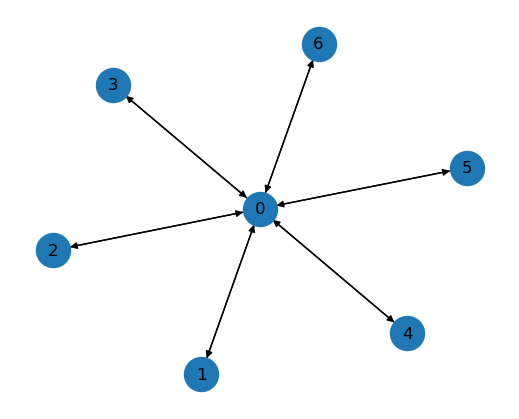

In [4]:

# star edges: 0 -> {1..6}
edge_index = torch.tensor([[0,0,0,0,0,0],
                           [1,2,3,4,5,6]], dtype=torch.long)

# make undirected (adds reverse edges)
edge_index = to_undirected(edge_index)
num_edges = edge_index.size(1)

# node features: 7 nodes, 1 feature each
x = torch.tensor([[0], [0], [0], [0], [0], [1], [1]], dtype=torch.float)

# edge features: match number of edges
edge_attr = torch.rand(num_edges, 1, dtype=torch.float)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
print(data)  # e.g., Data(edge_attr=[12, 1], edge_index=[2, 12], x=[7, 1])

# visualize with networkx
G = to_networkx(data, node_attrs=["x"], edge_attrs=["edge_attr"])
plt.figure(figsize=(5,4))
pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos, with_labels=True, node_size=600)
plt.show()

# --- DGL equivalent (optional) ---
# import dgl
# g = dgl.graph((edge_index[0], edge_index[1]), num_nodes=x.size(0))
# g = dgl.to_bidirected(g, copy_ndata=True, copy_edata=True)
# print(g)


# Dataset

In [5]:
# assumes these are defined in earlier cells:
# graph_type, fold, path_embeddings, embedding_layer, model_name, patch_size, magnifications
# is_neighbors, natural_keys

class VPCDataset(Dataset):
    def __init__(self, root, fold, magnifications, path_outcomes=None,
                 transform=None, pre_transform=None, pre_filter=None,
                 labels_csv=None):
        """
        root: base dir where embeddings are saved, e.g. '256_VPC_embeddings/'
        fold: e.g. 'fold1'
        magnifications: list like [40] or [10,20,40]
        path_outcomes: (optional) legacy PANDA/Zurich outcomes CSV
        labels_csv: (optional) patch-level labels CSV with 'path' and 'hard_label'
        """
        self.fold = fold
        self.magnifications = list(magnifications)
        self.embeddings_root = os.path.join(root, fold)  # e.g., 256_VPC_embeddings/fold1

        # Label source:
        self.core2label = None
        if labels_csv is not None:
            # derive a core-level label via majority vote over patches per core
            df = pd.read_csv(labels_csv)
            # core folder name is path split at -4: .../<core>/<size>/<mag>/<file.png>
            df = df.assign(core=df["path"].apply(lambda p: p.split("/")[-4]))
            # majority vote (mode); in ties, take the first mode
            core_labels = (
                df.groupby("core")["hard_label"]
                  .agg(lambda s: int(pd.Series(s).mode().iloc[0]))
                  .to_dict()
            )
            self.core2label = core_labels
        elif path_outcomes is not None:
            # legacy: external outcomes per core/slide (not used in VPC CSV flow)
            self.df = pd.read_csv(path_outcomes).reset_index(drop=True)
        # else: graphs will be saved with y = -1 (unknown)

        super().__init__(os.path.join(root, fold), transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        # Returning a placeholder to force `process()` unless processed exists.
        return ['_embeddings_ready']

    @property
    def processed_file_names(self):
        # List all processed graphs for this fold; if none, return a placeholder
        proc_dir = self.processed_dir
        if os.path.isdir(proc_dir):
            files = [f for f in os.listdir(proc_dir) if f.endswith(f'_{graph_type}.pt')]
            return files if files else ['_placeholder.pt']
        return ['_placeholder.pt']

    def download(self):
        # nothing to download
        pass

    def process(self):
        # use the embeddings directory directly
        base = self.embeddings_root
        if not os.path.isdir(base):
            raise FileNotFoundError(f"Embeddings directory not found: {base}")

        # enumerate cores (each subdir is a core like 'slide001_core003')
        cores = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
        # ignore any notebook checkpoints if present
        cores = [c for c in cores if c != '.ipynb_checkpoints']

        # local references
        mags = self.magnifications
        m = len(mags)
        patch_size_local = patch_size  # use global patch_size from your config

        for idx, core in enumerate(cores, 1):
            print(f'{core}, {idx}/{len(cores)}')

            # choose a graph label y (core-level). If unknown, set to -1.
            if self.core2label is not None:
                y = int(self.core2label.get(core, -1))
            else:
                y = -1  # unknown

            # load embeddings dicts for requested magnifications
            embd_paths = []
            for mag in mags:
                embd_path = os.path.join(base, core, str(patch_size_local), str(mag),
                                         f'{model_name}_{embedding_layer}.pkl')
                if not os.path.isfile(embd_path):
                    # skip cores that don't have this mag
                    continue
                embd_paths.append((mag, embd_path))

            if len(embd_paths) == 0:
                # no embeddings found for this core
                continue

            # keep order consistent with self.magnifications (for node layout)
            embd_paths.sort(key=lambda t: mags.index(t[0]))
            embd_dicts = []
            for _, pkl_path in embd_paths:
                with open(pkl_path, 'rb') as f:
                    embd_dicts.append(pickle.load(f))

            # keys are patch IDs like 'x_y'
            dict_keys = list(embd_dicts[0].keys())
            dict_keys.sort(key=natural_keys)
            # remove stray checkpoint keys
            dict_keys = [k for k in dict_keys if k != '.ipynb_checkpo']

            # features: [m, N, 512] then reshape to [m*N, 512] in column-major (order='F')
            N = len(dict_keys)
            x_np = np.zeros((len(embd_dicts), N, 512), dtype=np.float32)
            edge = []

            # edge type counters in the order we append edges
            edge_type_size = {}

            # ---- within-mag 4-neighbor edges ----
            for k, embd_dict in enumerate(embd_dicts):
                for i, key in enumerate(dict_keys):
                    x_np[k, i] = embd_dict[key]
                for i, key in enumerate(dict_keys):
                    for j, key_n in enumerate(dict_keys):
                        if is_neighbors(key, key_n, patch_size_local):
                            # global node index layout: [node0_mag0, node0_mag1, ..., node1_mag0, ...] with order='F'
                            edge.append([i * len(embd_dicts) + k, j * len(embd_dicts) + k])
                            et = f"{mags[k]}_{mags[k]}"
                            edge_type_size[et] = edge_type_size.get(et, 0) + 1

            # ---- cross-mag links (only if the mags exist) ----
            # link consecutive magnifications (e.g., 10<->20, 20<->40)
            for k in range(len(embd_dicts) - 1):
                left_mag  = mags[k]
                right_mag = mags[k + 1]
                et = f"{left_mag}_{right_mag}"
                et_rev = f"{right_mag}_{left_mag}"
                edge_type_size.setdefault(et, 0)
                edge_type_size.setdefault(et_rev, 0)
                for i in range(N):
                    # i@left <-> i@right (bidirectional)
                    edge.append([i * len(embd_dicts) + k,     i * len(embd_dicts) + (k + 1)])
                    edge.append([i * len(embd_dicts) + (k+1), i * len(embd_dicts) + k])
                    edge_type_size[et]     += 1
                    edge_type_size[et_rev] += 1

            # flatten features to [m*N, 512] with column-major order to match our node indexing
            x_np = np.reshape(x_np, (x_np.shape[0] * x_np.shape[1], x_np.shape[2]), order='F')

            # construct edge_index tensor [2, E]
            if len(edge) == 0:
                # graph with isolated nodes
                edge_index = torch.empty((2, 0), dtype=torch.long)
            else:
                e = torch.tensor(edge, dtype=torch.long).t()
                edge_index = e.detach()

            # build edge_type vector to match the order we appended edges
            # (first all within-mag in k order, then cross-mag blocks in k order)
            edge_type_blocks = []
            # within-mag blocks in k order
            for k in range(len(embd_dicts)):
                et = f"{mags[k]}_{mags[k]}"
                edge_type_blocks.extend([et] * edge_type_size.get(et, 0))
            # cross-mag consecutive blocks in k order (forward then reverse)
            for k in range(len(embd_dicts) - 1):
                et = f"{mags[k]}_{mags[k+1]}"
                edge_type_blocks.extend([et] * edge_type_size.get(et, 0))
                et_rev = f"{mags[k+1]}_{mags[k]}"
                edge_type_blocks.extend([et_rev] * edge_type_size.get(et_rev, 0))

            # map string types to integer ids (stable order by first appearance)
            etype_to_id = {}
            edge_type_ids = []
            for et in edge_type_blocks:
                if et not in etype_to_id:
                    etype_to_id[et] = len(etype_to_id)
                edge_type_ids.append(etype_to_id[et])
            edge_type = torch.tensor(edge_type_ids, dtype=torch.long) if len(edge_type_ids) > 0 else None

            # pack Data
            data = Data(
                x=torch.from_numpy(x_np),           # [m*N, 512]
                edge_index=edge_index,              # [2, E]
                y=torch.tensor([y], dtype=torch.long)  # graph label (core-level), -1 if unknown
            )

            if graph_type == 'heterogeneous' and edge_type is not None:
                data = data.to_heterogeneous(edge_type=edge_type)

            # user filters / transforms
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)

            # save once per core
            out_name = f'{core}_{graph_type}.pt'
            torch.save(data, os.path.join(self.processed_dir, out_name))

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, self.processed_file_names[idx]))
        return data


In [8]:
labels_csv = '../data/VPC/patch_labels_majority.csv'
magnifications = [10,20,40]

dataset = VPCDataset(
    root=path_embeddings,
    fold=fold,
    magnifications=magnifications,   # e.g., [40] or [10,20,40]
    labels_csv=labels_csv            
)

In [9]:
print(len(dataset))

244


In [10]:
a = np.array([[[1,2],[3,4]],[[5,6],[7,8]], [[9,10],[11,12]]])
print(a)

[[[ 1  2]
  [ 3  4]]

 [[ 5  6]
  [ 7  8]]

 [[ 9 10]
  [11 12]]]


In [11]:
print(np.reshape(a, (3*2,2), order='F'))

[[ 1  2]
 [ 5  6]
 [ 9 10]
 [ 3  4]
 [ 7  8]
 [11 12]]
